<a href="https://colab.research.google.com/github/oodlbee/drug_prediction/blob/master/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 69.1 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [4]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Предобработка

## Первый лист 1400

In [14]:
# df_1400 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1400.xlsx')
# df_1400.head()

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,Pictures
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,50.0
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,51.0
2,1008-Ya-187,9.9,144.0,14.545455,250.431,1,0,15.60,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,52.0
3,1009-As-106,8.3,500.0,60.240964,222.377,1,0,15.60,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,53.0
4,1010-Ya-208,39.4,143.0,3.629442,239.361,2,0,29.54,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,54.0


In [15]:
# df_1400.describe()

In [16]:
# df_1400_easy = df_1400.drop(["Title", "Pictures", "SMILES"], axis=1)
# df_1400_easy['SI'] = df_1400_easy['CC50-MDCK, mmg/ml']/df_1400_easy['IC50, mmg/ml']
# df_1400_easy.info()

In [17]:
# X = df_1400_easy.iloc[:, 3:]
# y = df_1400_easy.iloc[:, :3]
# X

In [18]:
# # Варианты целевой колонки
# y_si = y["SI"]
# y_ic = y["IC50, mmg/ml"]
# y_cc = y["CC50-MDCK, mmg/ml"]

In [19]:
# # Не забываем заменить агрумент 'y' при выборе другого целевого столбца
# X_train, X_test, y_train, y_test = train_test_split(X, y_ic,  test_size=0.25, random_state=42)

## Второй лист 1400

In [20]:
# df_1400_big = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/1400.xlsx', 1)
# df_1400_big.info()

In [21]:
# df_1400_big = df_1400_big.drop(['molecule', 'Pictures', 'SMILES', 'Unnamed: 55', 'Unnamed: 56'], axis=1)
# df_1400_big.dropna(inplace=True)

In [ ]:
# X = df_1400_big.iloc[:, 3:]
# y = df_1400_big.iloc[:, :3]
# y_si = y["SI"]
# y_ic = y["IC50, mmg/ml"]
# y_cc = y["CC50-MDCK, mmg/ml"]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_cc,  test_size=0.25, random_state=42)

## Уже обработанное

In [267]:
full = pd.read_csv("https://raw.githubusercontent.com/oodlbee/drug_prediction/master/processed_df.csv")
# full = pd.read_csv("https://raw.githubusercontent.com/oodlbee/drug_prediction/antons_branch/processed_df_without_corr.csv")
full.head(1)

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,#stars,...,SAfluorine,SAamideO,PSA,#NandO,RuleOfFive,#ringatoms,#in34,#in56,#noncon,#nonHatm
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,2.0,...,0.0,0.0,35.245,2.0,0.0,0.0,0.0,0.0,0.0,14.0


### Exploration

In [268]:
full.groupby(["CC50-MDCK, mmg/ml"])["CC50-MDCK, mmg/ml"].count().sort_values(), full.groupby(["CC50-MDCK, mmg/ml"])["CC50-MDCK, mmg/ml"].count().sort_values().mean()

(CC50-MDCK, mmg/ml
 0.031928        1
 96.900000       1
 97.000000       1
 97.400000       1
 97.900000       1
              ... 
 200.000000     11
 330.000000     12
 33.400000      16
 500.000000     31
 300.000000    248
 Name: CC50-MDCK, mmg/ml, Length: 690, dtype: int64,
 1.9086956521739131)

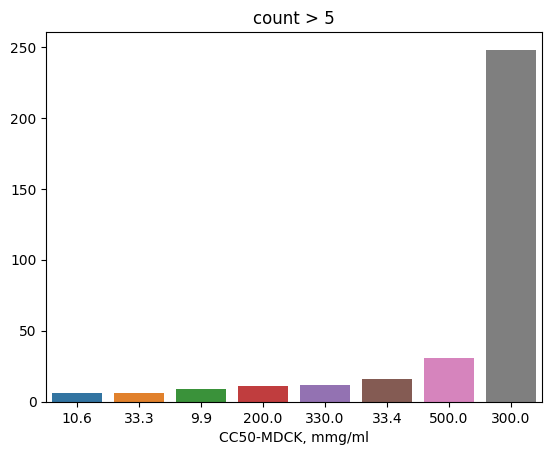

In [269]:
group=full.groupby(["CC50-MDCK, mmg/ml"])["CC50-MDCK, mmg/ml"].count()[full.groupby(["CC50-MDCK, mmg/ml"])["CC50-MDCK, mmg/ml"].count() > 5]

sns.barplot(x=group.index, y=group.values, order=group.sort_values().index)
plt.title("count > 5")
plt.show()

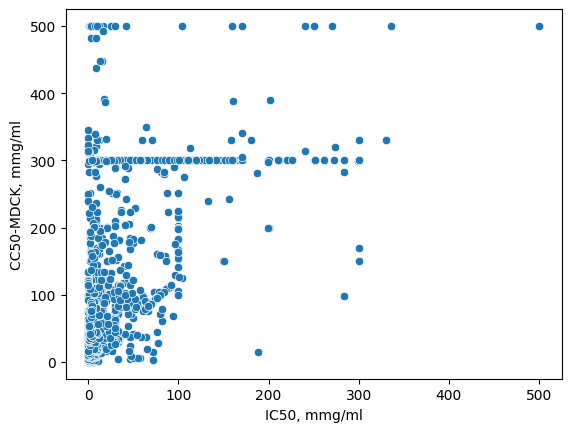

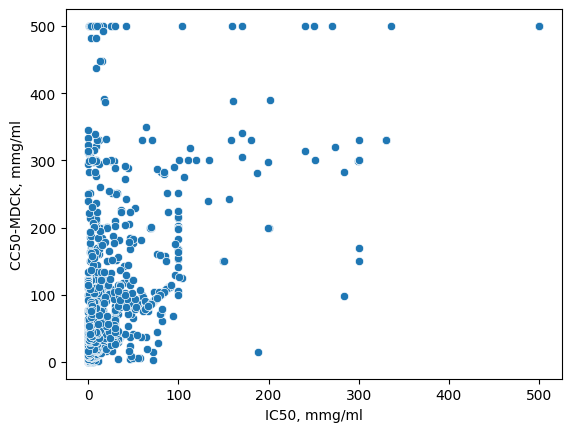

In [270]:
sns.scatterplot(full, x="IC50, mmg/ml", y="CC50-MDCK, mmg/ml")
plt.show()
full = full[full["CC50-MDCK, mmg/ml"]!=300.0]
# full = full[full["CC50-MDCK, mmg/ml"]!=500.0]
sns.scatterplot(full, x="IC50, mmg/ml", y="CC50-MDCK, mmg/ml")
plt.show()

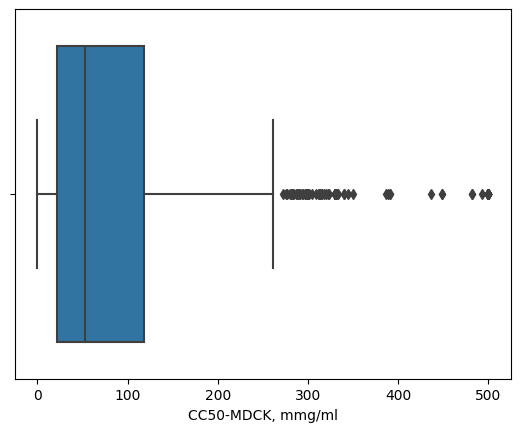

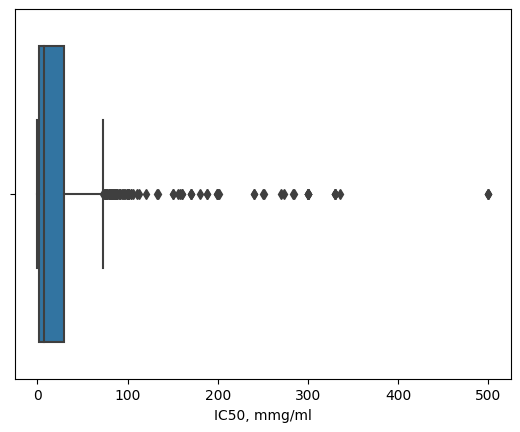

In [271]:
sns.boxplot(full, x="CC50-MDCK, mmg/ml")
plt.show()
sns.boxplot(full, x="IC50, mmg/ml")
plt.show()

### Обработка

In [272]:
# processed_smiles = pd.DataFrame(columns=Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(full['SMILES'][0])).keys())
# for i in range(full.shape[0]):
#     processed_smiles.loc[i] = Descriptors.CalcMolDescriptors(Chem.MolFromSmiles(full['SMILES'][i])).values()

In [273]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

# список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
processed_smiles = descriptors_transformer.transform(full['SMILES'])
processed_smiles

[10:43:38] Conflicting single bond directions around double bond at index 55.
[10:43:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:43:38] Conflicting single bond directions around double bond at index 55.
[10:43:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:43:38] Conflicting single bond directions around double bond at index 55.
[10:43:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:43:38] Conflicting single bond directions around double bond at index 55.
[10:43:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:43:38] Conflicting single bond directions around double bond at index 55.
[10:43:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:43:38] Conflicting single bond directions around double bond at index 55.
[10:43:38]   BondStereo set to STEREONONE and single bond directions set to NONE.
[10:43:38] Conflicting single bond direc

,HeavyAtomCount,NHOHCount,NOCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
0,14,1,2,2,1,2,2,80,0,0,2,195.306,2.26590,58.6168,32.59
1,18,0,2,2,0,2,5,104,0,0,2,250.430,3.61540,79.3190,15.60
2,16,0,2,2,0,2,3,92,0,0,2,222.376,2.83520,70.0850,15.60
3,17,0,3,3,0,3,3,98,0,0,2,239.359,2.30600,67.6630,29.54
4,41,0,4,2,0,4,16,236,0,0,4,570.995,8.44430,179.0658,24.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,18,0,3,3,0,3,7,102,1,0,1,252.354,3.71572,73.2770,39.44
1065,17,1,3,3,1,3,6,96,1,0,1,238.327,3.41272,68.3898,50.44
1066,17,0,3,3,0,3,6,96,1,0,1,238.327,3.32562,68.6600,39.44
1067,16,0,3,3,0,3,5,90,1,0,1,224.300,2.93552,64.0430,39.44


In [274]:
full.drop(["Title","SMILES"], axis=1, inplace=True)
full = full.join(processed_smiles)
full.dropna(inplace=True) # for all descriptors work
# full = pd.DataFrame(StandardScaler().fit_transform(full), columns=full.columns)

In [275]:
X = full.iloc[:, 3:]
y = full.iloc[:, :3]
y_si = y["SI"]
y_ic = y["IC50, mmg/ml"]
y_cc = y["CC50-MDCK, mmg/ml"]
X_train, X_test, y_train, y_test = train_test_split(X, y_ic,  test_size=0.25, random_state=42)

In [276]:
X.describe()

,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,#stars,#amine,#amidine,#acid,#amide,#rotor,...,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumAliphaticHeterocycles,RingCount,MW,LogP,MR,TPSA
count,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,...,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000,823.000000
mean,392.113081,3.897934,1.441069,82.495067,2.077764,0.204131,0.041312,0.140948,0.134872,6.188335,...,6.170109,4.475091,144.029162,1.839611,0.549210,3.599028,379.437227,3.639446,103.490091,78.042248
std,158.971852,2.891683,1.898550,58.052734,3.351838,0.492901,0.199132,0.426680,0.415674,5.652746,...,3.501162,3.445657,58.114905,1.394649,0.770311,1.458126,148.969641,1.875671,39.375266,53.654143
min,110.157000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,44.000000,0.000000,0.000000,1.000000,110.156000,-3.575830,30.455000,0.000000
25%,285.477000,2.000000,0.000000,39.105000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,3.000000,3.000000,112.000000,1.000000,0.000000,3.000000,286.341500,2.734060,78.081600,39.440000
50%,353.596000,3.000000,1.000000,69.650000,1.000000,0.000000,0.000000,0.000000,0.000000,5.000000,...,6.000000,4.000000,130.000000,2.000000,0.000000,3.000000,347.340000,3.608870,93.484500,69.650000
75%,450.514500,5.000000,2.000000,106.160000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,...,8.000000,6.000000,160.000000,3.000000,1.000000,4.000000,434.952500,4.682350,118.032950,96.890000
max,1159.380000,19.000000,9.000000,319.510000,17.000000,4.000000,1.000000,2.000000,4.000000,35.000000,...,21.000000,30.000000,460.000000,6.000000,4.000000,10.000000,1159.370000,12.367100,290.422100,319.510000


# Запуск моделей

## Линейная регрессия

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.610783851007, tolerance: 124.72789800195402
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345.6002814543899, tolerance: 131.7775609567486
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.328e+03, tolerance: 1.737e+02
  model = cd_fast.enet_coordinate_descent(


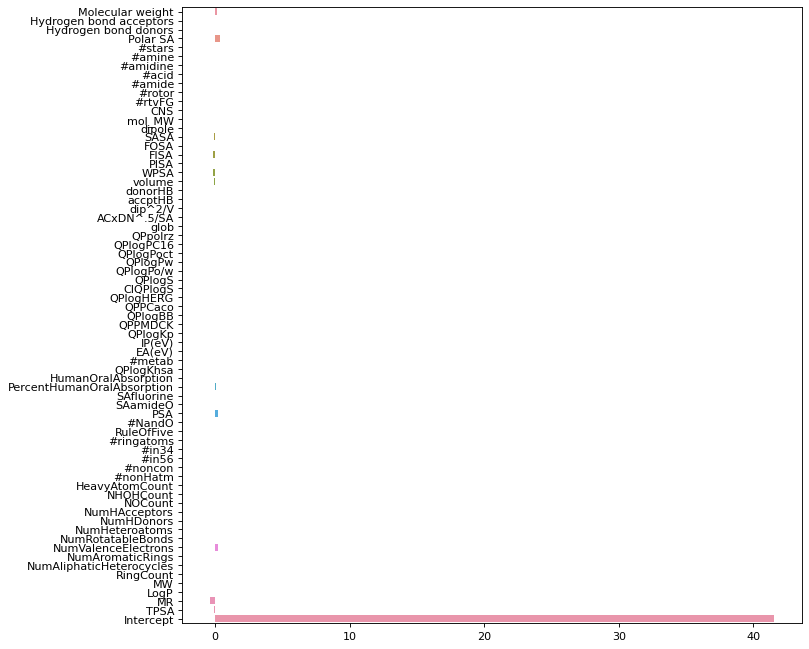

In [277]:
lasso = LassoCV(alphas = np.linspace(10, 25, 100), cv = 4, random_state = 13).fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(lasso.coef_, lasso.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

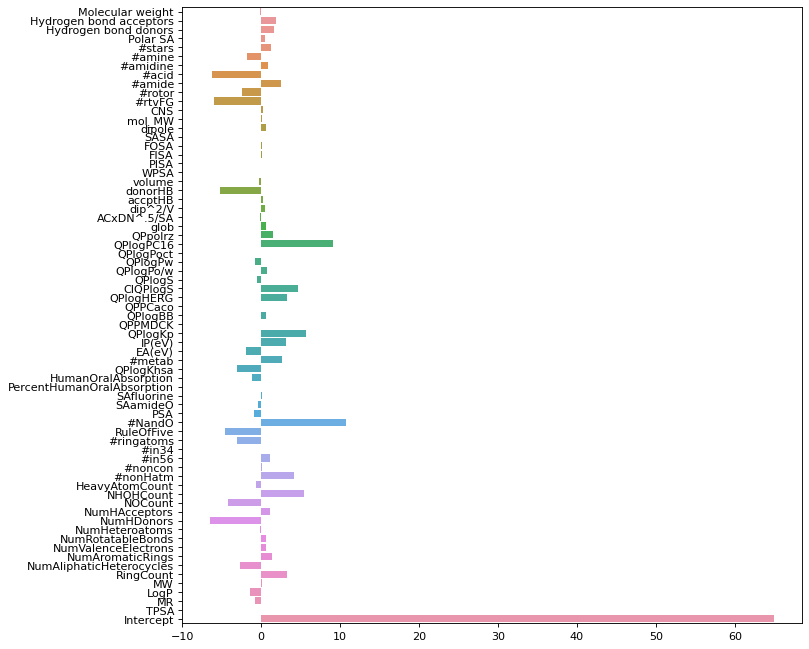

In [278]:
ridge = RidgeCV(alphas = np.linspace(10, 25, 100), cv = 4).fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(ridge.coef_, ridge.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

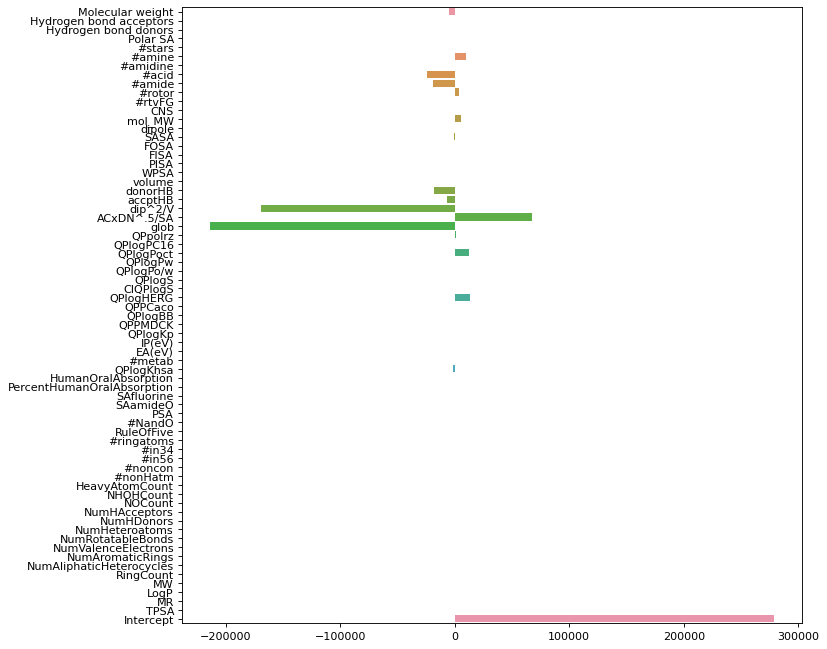

In [279]:
lr = LinearRegression().fit(X_train, y_train)
plt.figure(figsize=(10, 10), dpi=80)
coefs = np.append(lr.coef_, lr.intercept_)
names = list(X_train.columns)
names.append('Intercept')
g = sns.barplot(y=names, x=coefs)#, columns=X_train.columns)
plt.show()

## SVR

In [280]:
# line_param = np.linspace(0, 20, 20)
# parameters = {'kernel':('rbf', "poly", "sigmoid"), 'C':line_param}
# svr = make_pipeline(StandardScaler(), SVR())
# grid_search_svm = GridSearchCV(estimator=svr, param_grid=parameters, cv = 6)
# grid_search_svm.fit(X_train, y_train)
# svr = grid_search_svm.best_estimator_
svr = SVR().fit(X_train, y_train)
# svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
# svr.fit(X, y)

## Деревья (лес)

In [281]:
rf = RandomForestRegressor().fit(X_train, y_train)
# rf.score(X_test, y_test)

## Деревья (Бустинг)

In [282]:
# ada = AdaBoostRegressor().fit(X_train, y_train)
cat = CatBoostRegressor(4000, l2_leaf_reg=0.5).fit(X_train, y_train, early_stopping_rounds=10)

0:	learn: 52.6001185	total: 14.5ms	remaining: 57.9s
1:	learn: 52.2163159	total: 27.8ms	remaining: 55.5s
2:	learn: 51.7127718	total: 41.3ms	remaining: 55s
3:	learn: 51.3332339	total: 54.4ms	remaining: 54.3s
4:	learn: 50.9153433	total: 68.4ms	remaining: 54.7s
5:	learn: 50.4978721	total: 81.8ms	remaining: 54.5s
6:	learn: 49.9436887	total: 96.6ms	remaining: 55.1s
7:	learn: 49.5155258	total: 110ms	remaining: 54.9s
8:	learn: 49.2356127	total: 123ms	remaining: 54.5s
9:	learn: 48.8209656	total: 136ms	remaining: 54.2s
10:	learn: 48.3748017	total: 149ms	remaining: 54s
11:	learn: 47.9480000	total: 163ms	remaining: 54.1s
12:	learn: 47.5732963	total: 178ms	remaining: 54.6s
13:	learn: 47.1507976	total: 187ms	remaining: 53.4s
14:	learn: 46.7711805	total: 196ms	remaining: 52.1s
15:	learn: 46.5905091	total: 208ms	remaining: 51.8s
16:	learn: 46.1467624	total: 216ms	remaining: 50.6s
17:	learn: 45.7235935	total: 224ms	remaining: 49.6s
18:	learn: 45.2798532	total: 233ms	remaining: 48.8s
19:	learn: 45.05391

# Оценка моделей

In [283]:
def calc_metrics(model, X_test=X_test, y_test=y_test, df=None):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    r2 = model.score(X_test, y_test)
    pred_train = model.predict(X_train)
    mae_train = mean_absolute_error(y_train, pred_train)
    r2_train = model.score(X_train, y_train)
    if df is not None:
        df.loc[model_names[str(model)]] = [mae_train, mae, r2_train, r2]
    else:
        print(f"R-score: {r2}\nMAE: {mae}")

In [284]:
models = [lr, ridge, lasso, svr, rf,  cat]
model_names= {str(lr):"Linear", str(ridge):"Ridge", str(lasso):"Lasso", str(svr):"Support Vector", str(rf):"Random Forest",  str(cat):"Gradient Boosting"}
metrics = pd.DataFrame(columns=('MAE train', 'MAE test', 'R2 train', 'R2 test'))
for model in models:
    calc_metrics(model, df=metrics)
# metrics.loc["NN"] = [26.557213, 62.245403, 0.7994644949341713, 0.18156337322155136] # для cc
metrics.loc["NN"] = [4.23928, 4.734087942235035, 0.6373170348314735, 0.8188689012057118] # для ic
metrics.sort_values("MAE test")

,MAE train,MAE test,R2 train,R2 test
NN,4.239280,4.734088,0.637317,0.818869
Support Vector,20.644779,18.680507,-0.093245,-0.072537
Gradient Boosting,0.014495,21.505506,1.000000,0.128935
Random Forest,9.158170,23.207808,0.865628,0.154452
Lasso,26.282256,26.639481,0.127955,0.056810
Ridge,26.037215,28.533559,0.212848,0.023053
Linear,26.370754,29.239964,0.248236,0.029140


In [252]:
opa = pd.DataFrame({"Predicted": cat.predict(X_test), "True": y_test})
opa.describe()

,Predicted,True
count,206.000000,206.000000
mean,18.707030,20.941517
std,18.558110,53.506266
min,-9.132799,0.000037
25%,5.586686,1.925000
50%,13.991595,5.400000
75%,25.174078,14.750000
max,106.019253,500.000000
